In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
dataset = load_iris()
df = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
df['target'] = dataset['target']
df.head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0


In [3]:
sigma = np.cov(dataset['data'].T)
sigma.shape

(4, 4)

### 1. Principal Component Analysis (PCA) using optimization

Principal Component Analysis is a **constrained optimization problem** where the objective is to **maximize variance** of **linearly transformed component** given the constraint that the component is **normalized**. 

Computing 1st Principal Component using optimization.

In [4]:
func = lambda w: - w.T @ sigma @ w
consts = ({'type':'eq', 'fun': lambda w: w.T @ w - 1})

w0 = np.array([2,-1,8,2])
sol = minimize(func, w0, constraints=consts)
sol

     fun: -4.2282417068492295
     jac: array([-3.05606008,  0.71476322, -7.24442077, -3.02986652])
 message: 'Optimization terminated successfully'
    nfev: 58
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([ 0.36138824, -0.08452356,  0.8566701 ,  0.3582885 ])

In [5]:
# getting 1st principal component using Sklearn library
pca = PCA(n_components=1)
pca.fit(dataset['data'])
pca.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ]])

In [6]:
result1 = dataset['data'] @ sol.x
result2 = np.squeeze(pca.transform(dataset['data']))

var1 = np.var(result1)
var2 = np.var(result2)
total_var = np.trace(sigma)

# variances obtained from two approaches is similar
assert np.isclose(var1, var2)

# variance ratios obtained from two approaches is similar
assert np.isclose(var1 / total_var, var2 / total_var)

print(var2)
print(pca.explained_variance_.item())

4.200053427994632
4.228241706034863


### 2. Eigenvalue analysis in PCA

The solution of problem of PCA results into an **eigenvalue problem**. Let's understand this with another example.

In [7]:
data = load_breast_cancer()
df = pd.DataFrame(data['data'], columns = data['feature_names'])
df['target'] = data['target']

cols = list(df.columns)
cols.remove('target')
X = df[cols]
y = df['target']

In [8]:
var_covar_matrix = np.cov(X.transpose())
var_covar_matrix.shape

(30, 30)

In [9]:
eigenvalues = np.linalg.eig(var_covar_matrix)[0]
eigenectors = np.linalg.eig(var_covar_matrix)[1]

# arranging eigenvalues in decreasing order
eigenvalues.sort()
eigenvalues = eigenvalues[::-1]
eigenvalues[:2] / sum(eigenvalues)

array([0.98204467, 0.01617649])

In [10]:
pca=PCA(n_components=2)
pca_data=pca.fit_transform(X)

print('Variance Ratio (same as above): ', pca.explained_variance_ratio_)
print('Total Variance Explained: ', sum(pca.explained_variance_ratio_))

Variance Ratio (same as above):  [0.98204467 0.01617649]
Total Variance Explained:  0.9982211613741724


Total Variance of data is given by trace of variance-covariance matrix.

In [11]:
total_pca_variance = np.trace(np.cov(pca_data.transpose()))
total_variance = np.trace(np.cov(X.transpose()))

print('Total Variance explained by transformed data:', total_pca_variance)
print('Total Variance of the original data:', total_variance)

print('\nVariance explained by PCA (same as above):', total_pca_variance/total_variance)

Total Variance explained by transformed data: 451092.7052082499
Total Variance of the original data: 451896.5562573987

Variance explained by PCA (same as above): 0.9982211613741732


### 3. Visualization of PCA v/s K-Means Clustering

1st two components can explain 99% of variance in the dataset.

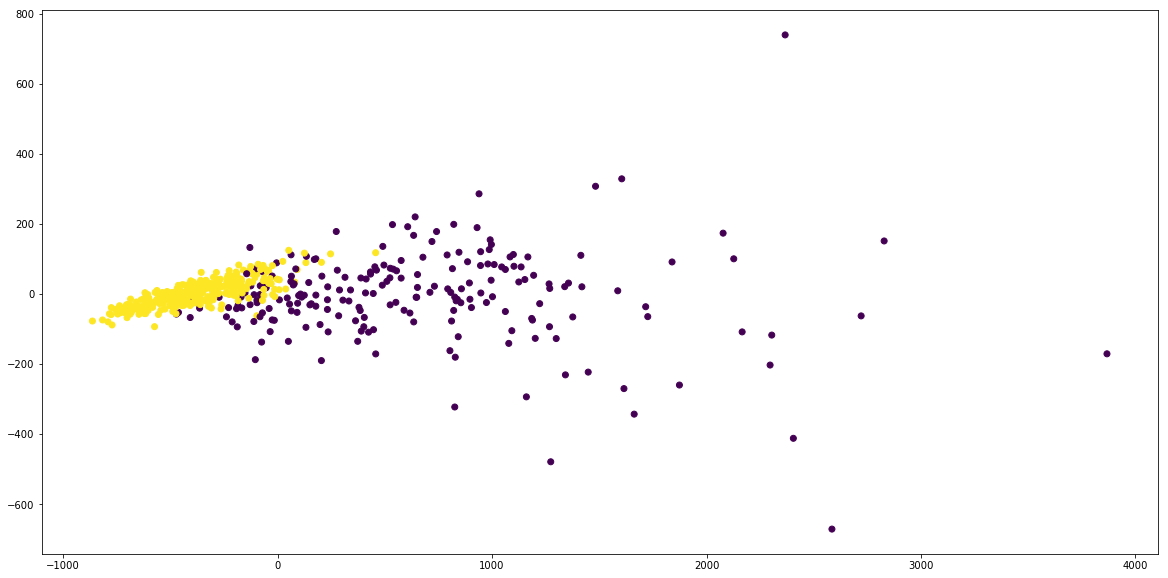

In [12]:
fig = plt.figure(figsize = (20, 10))
plt.scatter(pca_data[:,0], pca_data[:,1], c=y)
plt.show()

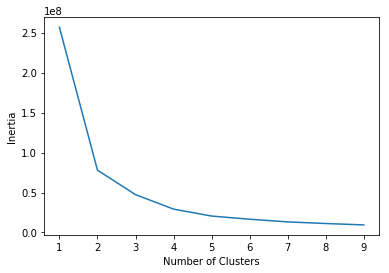

In [13]:
def compute_inertia(X, n_clusters):
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(X)
    return kmeans.inertia_

max_clusters = 10
inertia = list(map(lambda n: compute_inertia(X, n), range(1, max_clusters)))

plt.plot(range(1, max_clusters), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

The optimal number of clusters is 2 with Elbow method.

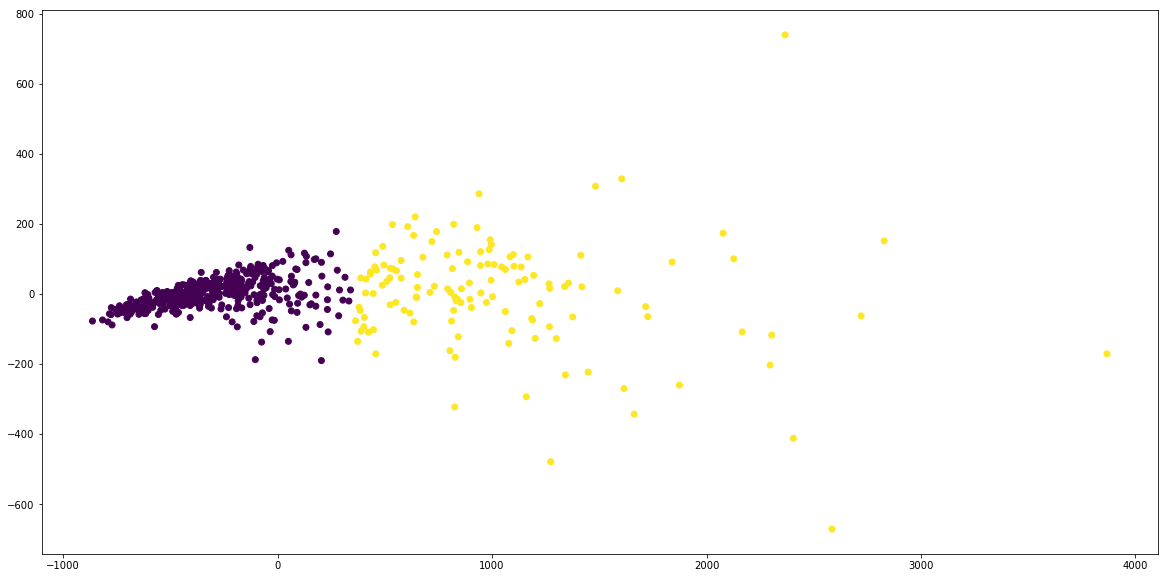

In [14]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(X)
cluster_label = kmeans.labels_

pca = PCA(n_components = 2)
pca_data = pca.fit_transform(X)

fig = plt.figure(figsize = (20, 10))
plt.scatter(pca_data[:,0], pca_data[:,1], c=cluster_label)
plt.show()

We notice a variation between the two plots. This is because KMeans has clustered some data points incorrectly (around X=0) as it makes spherical clusters (with Euclidean distance as default distance metric) and due to it's inability to make non-convex clusters. 

Let's look at the accuracy of clustering.

In [15]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y, cluster_label)

if acc_score < 0.5:
    # do label switch
    cluster_label = np.where(cluster_label==1, 0, 1)
    acc_score = accuracy_score(y, cluster_label)

acc_score

0.8541300527240774